In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
import seaborn as sns
import logging

In [2]:
# getting the dataset for training 
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2025-05-17 13:48:18--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.1’

input.txt.1         100%[===================>]   1.06M  --.-KB/s    in 0.05s   

2025-05-17 13:48:19 (21.0 MB/s) - ‘input.txt.1’ saved [1115394/1115394]



In [3]:
# set up logging


In [4]:
class PreprocessingTraining():
    def __init__(self, text, batch_size = 4, time_steps = 8):
        self.text = text
        self.dataset_size = len(self.text)
        self.vocab = sorted(set(self.text)) # number of distinct tokens in the dataset (for our model token is a character)
        self.vocab_size = len(self.vocab)
        self.Batch = batch_size # we create a batch of 4 chunks which can be processed paralllely by our language model
        self.Time = time_steps
        
        # Tokenization is the process of splitting text into units (tokens) like characters, words, or subwords,
        # and mapping each token to a unique numerical ID for model input.
        self.str_to_int = {char:index for index, char in enumerate(self.vocab)}
        self.int_to_str = {index:char for index, char in enumerate(self.vocab)}

        # Split the dataset once for reusability
        self.train_text, self.val_text, self.test_text = self.train_test_validation_split()

    def encoding(self, st: str):
        return [self.str_to_int[char] for char in st]

    def decoding(self, li: list):
        return ''.join([self.int_to_str[i] for i in li])


    def train_test_validation_split(self):
        """
        Splits the dataset into train (81%), validation (9%), and test (10%).
    
        - First 90% is training+validation
        - Last 10% is test
        - From the 90%, 10% is taken as validation (i.e., 9% of total)
        """
    
        split_index_test = int(0.9 * len(self.text))
        train_val_text = self.text[:split_index_test]
        test_text = self.text[split_index_test:]

        split_index_val = int(0.9 * len(train_val_text))
        train_text = train_val_text[:split_index_val]
        val_text = train_val_text[split_index_val:]

        return train_text, val_text, test_text

    def get_batch_indices(self, split:'train'):
        torch.manual_seed(1337)
        data = {'train': self.train_text, 'validation': self.val_text, 'test': self.test_text}[split]
        # we are seeding our torch random generator so that when we reproduce or rerurn this code, we always get same random numbers
        batch_indices = torch.randint(0, len(data)-self.Time, (self.Batch,))
        # we are generating 4 random indices which can be any integers between 0 and len(data)-block_size which is Time
        return batch_indices

    def get_batch_of_chunks(self, split: 'train'):
        batch_indices = self.get_batch_indices(split)
        data = {
            'train': self.train_text,
            'validation': self.val_text,
            'test': self.test_text
        }[split]
        x = torch.stack([torch.tensor(self.encoding(data[i:i+self.Time])) for i in batch_indices])
        y = torch.stack([torch.tensor(self.encoding(data[i+1:i+self.Time+1])) for i in batch_indices])
        return x, y    

In [5]:
"""
BIGRAM MODEL – EXPLANATION AND INTUITION

This is a simple character-level bigram language model.
It learns to predict the next character based only on the current one — no memory of earlier tokens.

1. INPUT:
   - The model receives input as tokenized character sequences.
   - Shape: (B, T), where:
     B = batch size (number of sequences),
     T = time steps (tokens per sequence).

2. MODEL:
   - A single embedding layer: nn.Embedding(vocab_size, vocab_size)
     This serves as a lookup table: for each token ID, we directly get logits over all possible next tokens.
   - The output of the embedding has shape (B, T, vocab_size).
     That means: for each token at each position in each sequence, we get one row of logits.

3. TARGET:
   - Also shape (B, T), these are the "ground truth" next tokens the model should predict.
   - Typically obtained by shifting the input by one position to the right.

4. LOSS (Cross-Entropy):
   - The model uses torch.nn.functional.cross_entropy to compare predicted logits to target tokens.
   - Logits are raw scores → cross_entropy automatically applies softmax inside.
   - Reshape needed:
       logits: (B, T, vocab_size) → (B*T, vocab_size)
       targets: (B, T) → (B*T)
   - Loss is the negative log-probability assigned to the correct token.

5. INTERPRETING INITIAL LOSS (Before Training):
   - At initialization, the logits are random and the softmax output is nearly uniform.
   - If vocab_size = 65, then each token has roughly 1/65 probability → log(1/65) ≈ -4.17
   - So initial loss should be around 4.17

   What loss tells us:
   - **Loss ≈ 4.17**: sanity check — model is untrained, predictions are near uniform.
   - **Loss << 4.17** before training: suspicious — possibly overfitting, data leak, or label issues.
   - **Loss >> 4.17**: model might be confidently wrong — spiky logits focused on incorrect tokens due to bad initialization.

6. TRAINING:
   - This model has no hidden layers, attention, or MLPs.
   - The only trainable component is the embedding matrix (vocab_size × vocab_size),
     which directly learns the conditional probability of every possible next character given the current one.
   - It essentially "memorizes" next-token frequencies.

7. WHY THIS MODEL IS IMPORTANT:
   - You can build a non-neural bigram model using raw token pair frequencies.
   - But this neural version introduces you to:
       - Training via gradient descent
       - Backpropagation
       - Autograd and loss functions
     ... which are foundational for scaling up to real transformer-based LLMs.

8. BIGRAM vs TRANSFORMER:
   - In bigram models, C (channel size) = vocab_size
   - In real transformers, C is a hidden dimension (e.g., 128 or 512),
     and only the final linear layer projects to vocab_size for logits.
   - Deeper models allow modeling longer-term dependencies, while this bigram model only looks one token back.
"""


'\nBIGRAM MODEL – EXPLANATION AND INTUITION\n\nThis is a simple character-level bigram language model.\nIt learns to predict the next character based only on the current one — no memory of earlier tokens.\n\n1. INPUT:\n   - The model receives input as tokenized character sequences.\n   - Shape: (B, T), where:\n     B = batch size (number of sequences),\n     T = time steps (tokens per sequence).\n\n2. MODEL:\n   - A single embedding layer: nn.Embedding(vocab_size, vocab_size)\n     This serves as a lookup table: for each token ID, we directly get logits over all possible next tokens.\n   - The output of the embedding has shape (B, T, vocab_size).\n     That means: for each token at each position in each sequence, we get one row of logits.\n\n3. TARGET:\n   - Also shape (B, T), these are the "ground truth" next tokens the model should predict.\n   - Typically obtained by shifting the input by one position to the right.\n\n4. LOSS (Cross-Entropy):\n   - The model uses torch.nn.functional

In [26]:
class BigramModel(nn.Module):
    # input is of shape (B,T)
    # B: batch size (number of sequences we're processing at once)
    # T: Time steps (length of each sequence)
    # output: shape (B, T, C)
    def __init__(self, vocab_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.token_lookup_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, x, targets = None):
        logits = self.token_lookup_table(x) # (B, T, C = vocab_size)
        loss = None
        if targets is not None:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate_sequence(self,input_ids, max_tokens_ahead: int):
        for _ in range(max_tokens_ahead):
            logits, _ = self.forward(input_ids)
            # we need to get logits for only the last token, so that we can predict its next token till we generate max_tokens_ahead 
            logits = logits[:, -1, :] 
            # getting logit of only the last token in the input because we only need current token to predict next token, 
            # so we pluck logits of C length for last elements from sequence in each batch 
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            next_token = torch.multinomial(probs, num_samples = 1) # (B,1) in each of the batch dimensions, we will have a single prediction for what comes next
            # we concat this new token to out input 
            new_input = torch.cat([input_ids, next_token], dim = 1) # so the new shape becomes (B, T+1)
            input_ids = new_input
        return input_ids

    def train_loop(self, get_batch_fn, prep, steps = 1000, print_every=100):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-3)
        self.train() # set model to training mode
        losses = []
        for step in range(steps):
            xb, yb = get_batch_fn('train')
            logits, loss = self.forward(xb, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

            if step % print_every == 0:
                print(f'Step {step}, Loss: {loss.item():.4f}')
                # trying a generation to see how model is performing at this step during training
                prompt = "Th"
                input_ids = torch.tensor([prep.encoding(prompt)])
                sample = self.generate_sequence(input_ids, 50)
                decoded = prep.decoding(sample[0].tolist())
                print(f"Sample generation for Th at step {step}: {decoded}\n")
        # store for plotting
        self.losses = losses

    def plot_loss(self):
        if hasattr(self, 'losses'):
            plt.plot(self.losses)
            plt.xlabel('Training steps')
            plt.ylabel('Cross entropy loss')
            plt.title('Training loss over time')
            plt.grid(True)
            plt.show()
        else:
            print('No losses recorded. Did you run the training loop?')


Initial loss should be ~4.17 before training. Loss before training: 4.5893
Step 0, Loss: 4.5893
Sample generation for Th at step 0: ThzcPU3pkqvL.ejNTCy?KBHAP xydB&CXxzAYcmOAq'PLK
Y;Gkr

Step 100, Loss: 4.3997
Sample generation for Th at step 100: ThzcPU3pkqvL.ejNTCy?KBHAP xydB&CXxzAYcmOAq'PLK
Y;Gkr

Step 200, Loss: 4.2130
Sample generation for Th at step 200: ThzcPU3pkqvL.ejNTCy?KBHAP xydB&CXxzAYcmOAq'PLK
Y;Gkr

Step 300, Loss: 4.0292
Sample generation for Th at step 300: ThzcPU3pkqvL.ejNTCy?KBHAP xydB&CXxzAYcmOAq'PhK
Y;Gkr

Step 400, Loss: 3.8481
Sample generation for Th at step 400: ThzcPU3pkqvL.ejNTCy?KBHAP xydB&CXxzAYcmOAq'PhK
Y;Gkr

Step 500, Loss: 3.6702
Sample generation for Th at step 500: ThzcPU3pkqvL.ejNTCy?KBHAP xydB&CXxzAYcmOAq'PhK
Y;Gkr

Step 600, Loss: 3.4959
Sample generation for Th at step 600: ThzcPU3pkqvL.ejNTCy?KBHAP xydB&CXxzAYcmOAq'PhK
Y;Gkr

Step 700, Loss: 3.3256
Sample generation for Th at step 700: ThzcPU3pkqvL.ejNTCy?KBHAP xydB&CXxzAYcmOAq'PhK
Y;Gkr

Step 800,

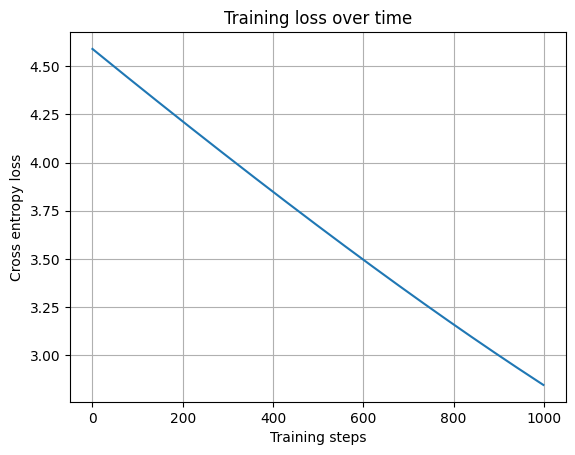

Post-training loss: 2.8446
ThzcPU3pkqvL.ejNTCy?KBHAP xydB&CXxzAYcmOAq'PhK
Y;GkraiXaWg;tkjCAMllIRl;bjtpOWt mRfd.Q'McvsEPZEMf.WLbjM


In [27]:
# driver code
# load data
with open("input.txt", "r") as f:
    raw_text = f.read()

# initialising preprocessing and bigram model
prep = PreprocessingTraining(raw_text)
model = BigramModel(prep.vocab_size)

# forward pass before training (sanity check)
xb, yb = prep.get_batch_of_chunks("train")
_, loss_before = model(xb, yb)
print(f"Initial loss should be ~4.17 before training. Loss before training: {loss_before.item():.4f}")

# == Optional training flag == 
should_train = True
if should_train:
    model.train_loop(prep.get_batch_of_chunks, prep, steps=1000, print_every = 100)

# plotting loss over course of training
model.plot_loss()

# Evaluate again after training
_, loss_after = model(xb, yb)
print(f"Post-training loss: {loss_after.item():.4f}")

# Generate new text from a short prompt
prompt= 'Th'
input_ids = torch.tensor([prep.encoding(prompt)])
generated_ids = model.generate_sequence(input_ids, 100)
print(prep.decoding(generated_ids[0].tolist()))